# Update Statistics(Average, Standard Deviation)

<pre>
Frozen, Dynamics, Moving Boundary를 이용하기 위하여 직전 N개의 데이터를 이용합니다.

다만, M개의 변수마다 N개의 데이터를 이용한다면 M * N개의 데이터 포인트를 가져야 하므로 부하가 높아질 가능성이 있습니다.

따라서, 새로운 데이터가 추가될 때 통계치(평균, 표준편차)를 업데이트하고자 합니다.

update_avg_std.py에 필요한 함수들을 작성하였으며 사용법은 아래와 같습니다.

1. 사용 방법
2. 활용 사례
</pre>

### Import Library

In [1]:
import os, sys
import numpy as np

# 상위 디렉토리로 경로를 설정합니다.
sys.path.append(os.path.abspath('../'))

# 사용자 정의 모듈을 불러옵니다.
from classify_fault.update_avg_std import update_avg_std

## 1. 사용 방법

### Add new value to data

In [2]:
sample = [2, 3, 4, 5, 6, 10, 15, 20]
new_value = 30

avg = np.mean(sample)
std = np.std(sample)

print(f"평균: {avg} \t 표준편차: {std}")

평균: 8.125 	 표준편차: 5.988269783501742


In [3]:
avg_new, std_new = update_avg_std(avg_old=avg, std_old=std, new_value=new_value, 
                                  update_option='increase', oldest_value=sample[0], 
                                  data_size=len(sample))
print(f"평균: {avg_new} \t 표준편차: {std_new} \n")

# Compare : add new value to sample data
sample.append(new_value)
print("sample added new value", sample)
avg_new_ = np.mean(sample)
std_new_ = np.std(sample)

print(f"평균: {avg_new_} \t 표준편차: {std_new_}")

평균: 10.555555555555555 	 표준편차: 8.89583062277693 

sample added new value [2, 3, 4, 5, 6, 10, 15, 20, 30]
평균: 10.555555555555555 	 표준편차: 8.89583062277693


### Add data while keeping the data size constant

In [4]:
sample = [2, 3, 4, 5, 6, 10, 15, 20]
new_value = 30

avg = np.mean(sample)
std = np.std(sample)

print(f"평균: {avg} \t 표준편차: {std}")

평균: 8.125 	 표준편차: 5.988269783501742


In [5]:
avg_new2, std_new2 = update_avg_std(avg_old=avg, std_old=std, new_value=new_value, 
                                    update_option='keep size', oldest_value=sample[0], 
                                    data_size=len(sample))
print(f"평균: {avg_new2} \t 표준편차: {std_new2} \n")

# Compare
sample.append(new_value)
sample.remove(sample[0])
print("sample added new value", sample)
avg_new_ = np.mean(sample)
std_new_ = np.std(sample)

print(f"평균: {avg_new_} \t 표준편차: {std_new_}")

평균: 11.625 	 표준편차: 8.87323926196065 

sample added new value [3, 4, 5, 6, 10, 15, 20, 30]
평균: 11.625 	 표준편차: 8.87323926196065


## 2. 활용 사례
### Moving Boundary 활용법

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

In [54]:
data_path = '../data/Temperature.csv'
data = pd.read_csv(data_path, index_col=[0])
test_tag_list = ['temp5All']
data = data[test_tag_list].values[: 250].ravel()

data = list(data)

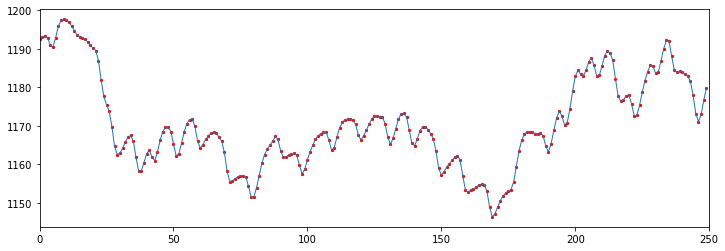

In [55]:
plt.figure(figsize=(12, 4))
plt.plot(data, linewidth=1)
plt.scatter(x=np.arange(0, len(data), 1), y=data, color='r', s=5)
plt.xlim(0, len(data))
plt.show();

In [56]:
# 위와 같은 데이터의 5개 평균을 모니터링한다고 가정하자.
window_size = 5

avg_old = np.mean(data[:window_size])
std_old = np.std(data[:window_size])

avgs, stds = [avg_old], [std_old]
avg_new = deepcopy(avg_old)
std_new = deepcopy(std_old)

for j in range(window_size, len(data)):
    avg_new, std_new = update_avg_std(avg_old=avg_new, std_old=std_new, 
                                      new_value=data[j],
                                      update_option='keep size', 
                                      oldest_value=data[j-window_size], 
                                      data_size=window_size)
    avgs.append(avg_new)
    stds.append(std_new)

In [57]:
avg_init = np.mean(data[:window_size])
std_init = np.std(data[:window_size])
print(avg_init, std_init)

avgs = [avg_init for _ in range(window_size-1)] + avgs
stds = [std_init for _ in range(window_size-1)] + stds

lower_boundary = [avg - 3 * std for avg, std in zip(avgs, stds)]
upper_boundary = [avg + 3 * std for avg, std in zip(avgs, stds)]

1192.604 0.8587805307527646


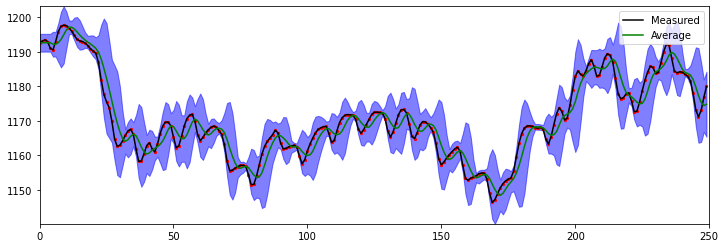

In [58]:
plt.figure(figsize=(12, 4))
plt.fill_between(np.arange(0, len(data), 1),  
                 lower_boundary, upper_boundary, alpha=0.5, color='b')

plt.plot(data, label="Measured", c='k')
plt.scatter(x=np.arange(0, len(data), 1), y=data, color='r', s=5)
plt.plot(avgs, label='Average', c='g', linewidth=1.5)


plt.legend(loc='upper right')
plt.xlim(0, min(len(data), 250))
plt.ylim(min(lower_boundary), max(upper_boundary))
plt.show();

In [59]:
df = pd.DataFrame(data, columns=['value'])
rolling_mean = list(df['value'].rolling(window_size).mean().fillna(avg_init).values)
rolling_std = list(df['value'].rolling(window_size).std().fillna(std_init).values)

lower_rolling = [avg - 3 * std for avg, std in zip(rolling_mean, rolling_std)]
upper_rolling = [avg + 3 * std for avg, std in zip(rolling_mean, rolling_std)]

In [60]:
rolling_mean, rolling_std = [], []

for i in range(len(df['value'])):    
    if i < window_size:
        mu, sigma = avg_init, std_init
    else:
        data_include_past = data[i - window_size + 1: i + 1]
        mu, sigma = np.mean(data_include_past), np.std(data_include_past)

    rolling_mean.append(mu)
    rolling_std.append(sigma)

lower_rolling = [avg - 3 * std for avg, std in zip(rolling_mean, rolling_std)]
upper_rolling = [avg + 3 * std for avg, std in zip(rolling_mean, rolling_std)]

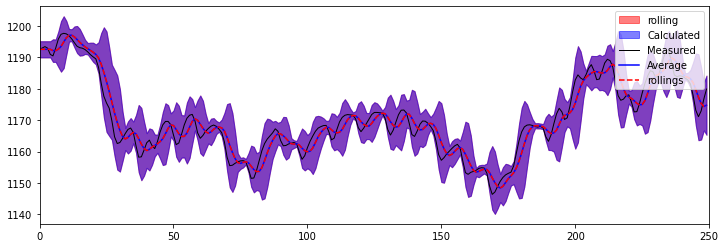

In [61]:
plt.figure(figsize=(12, 4))

plt.fill_between(np.arange(0, len(data), 1),  
                 lower_rolling, upper_rolling, alpha=0.5, color='r', label='rolling')

plt.fill_between(np.arange(0, len(data), 1),  
                 lower_boundary, upper_boundary, alpha=0.5, color='b', label='Calculated')

plt.plot(data, label="Measured", linewidth=1, c='k')
plt.plot(avgs, label='Average', linewidth=1.5, c='b')
plt.plot(rolling_mean, label='rollings', linewidth=1.5, linestyle='--', c='r')

plt.legend(loc='upper right')
plt.xlim(0, min(len(data), 250))
plt.show();

In [62]:
sum_diff_avgs = sum([roll - calc for roll, calc in zip(rolling_mean, avgs)])
sum_diff_stds = sum([roll - calc for roll, calc in zip(rolling_std, stds)])

print(sum_diff_avgs, sum_diff_stds)

# >>> -6.873506208648905e-10 -1.3075791560623884e-09
#     --> 차이가 거의 없음, 즉 과거 데이터를 가져와서 계산할 때와 다르지 않음.

-6.873506208648905e-10 -1.3075791560623884e-09


dataframe의 rolling()을 사용하여 update_avg를 검증하였고 그 결과는 같았음.

<pre>
위 와 같이 Moving Boundary를 쉽게 이용할 수 있다.

아래의 두 값과 평균 값들만 모니터링 할 수 있다.
data[j]: 현재 관측되는 값
data[j-window_size]: Window Size 이전 값

가령 Window Size가 10개라면 
변수 1개 당 과거 값 10개가 모두를 활용하여 Moving Average를 모니터링하는 것이 아니라
평균, 현재 값 , 초기값 3개만 이용하여 Moving Average를 모니터링할 수 있다.
</pre>

In [82]:
data2 = pd.read_csv('../data/도시가스공급망데이터_루프B_PRS2.csv', index_col=[0])
data2 = data2['운남삼성_PRS2'].values[: ].ravel()
data2 = list(data2)

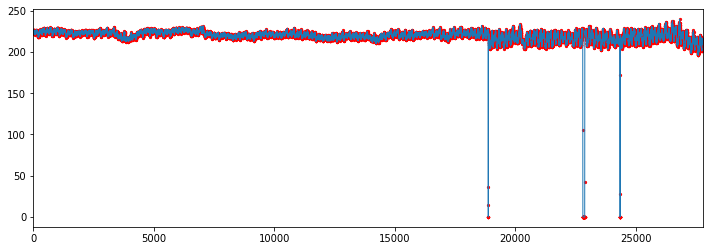

In [83]:
plt.figure(figsize=(12, 4))
plt.plot(data2, linewidth=1)
plt.scatter(x=np.arange(0, len(data2), 1), y=data2, color='r', s=5)
plt.xlim(0, len(data2))
plt.show();

In [90]:
# 위와 같은 데이터의 5개 평균을 모니터링한다고 가정하자.
window_size = 288

avg_old = np.mean(data2[:window_size])
std_old = np.std(data2[:window_size])

avgs, stds = [avg_old], [std_old]
avg_new = deepcopy(avg_old)
std_new = deepcopy(std_old)

for j in range(window_size, len(data2)):
    avg_new, std_new = update_avg_std(avg_old=avg_new, std_old=std_new, 
                                      new_value=data2[j],
                                      update_option='keep size', 
                                      oldest_value=data2[j-window_size], 
                                      data_size=window_size)
    avgs.append(avg_new)
    stds.append(std_new)
	
avg_init = np.mean(data2[:window_size])
std_init = np.std(data2[:window_size])
print(avg_init, std_init)

avgs = [avg_init for _ in range(window_size-1)] + avgs
stds = [std_init for _ in range(window_size-1)] + stds

lower_boundary = [avg - 3 * std for avg, std in zip(avgs, stds)]
upper_boundary = [avg + 3 * std for avg, std in zip(avgs, stds)]

223.39420486111112 1.9756317896937658


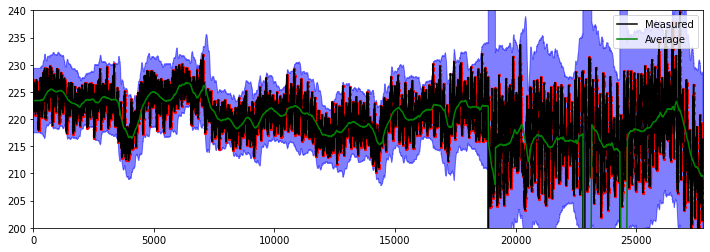

In [98]:
plt.figure(figsize=(12, 4))
plt.fill_between(np.arange(0, len(data2), 1),  
                 lower_boundary, upper_boundary, alpha=0.5, color='b')

plt.plot(data2, label="Measured", c='k')
plt.scatter(x=np.arange(0, len(data2), 1), y=data2, color='r', s=5)
plt.plot(avgs, label='Average', c='g', linewidth=1.5)


plt.legend(loc='upper right')
plt.xlim(0, len(data2))
plt.ylim(200, 240)
plt.show();

In [95]:
df = pd.DataFrame(data2, columns=['value'])
rolling_mean, rolling_std = [], []

for i in range(len(df['value'])):    
    if i < window_size:
        mu, sigma = avg_init, std_init
    else:
        data2_include_past = data2[i - window_size + 1: i + 1]
        mu, sigma = np.mean(data2_include_past), np.std(data2_include_past)

    rolling_mean.append(mu)
    rolling_std.append(sigma)

lower_rolling = [avg - 3 * std for avg, std in zip(rolling_mean, rolling_std)]
upper_rolling = [avg + 3 * std for avg, std in zip(rolling_mean, rolling_std)]

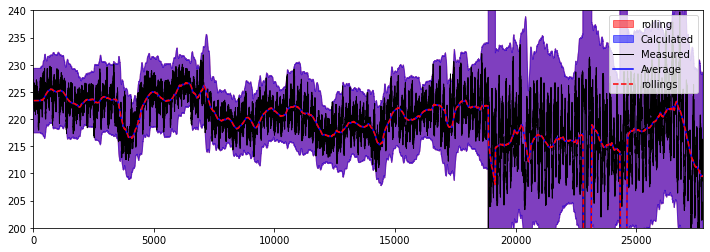

In [101]:
plt.figure(figsize=(12, 4))

plt.fill_between(np.arange(0, len(data2), 1),  
                 lower_rolling, upper_rolling, alpha=0.5, color='r', label='rolling')

plt.fill_between(np.arange(0, len(data2), 1),  
                 lower_boundary, upper_boundary, alpha=0.5, color='b', label='Calculated')

plt.plot(data2, label="Measured", linewidth=1, c='k')
plt.plot(avgs, label='Average', linewidth=1.5, c='b')
plt.plot(rolling_mean, label='rollings', linewidth=1.5, linestyle='--', c='r')

plt.legend(loc='upper right')
plt.xlim(0, len(data2))
plt.ylim(200, 240)
plt.show();

In [97]:
sum_diff_avgs = sum([roll - calc for roll, calc in zip(rolling_mean, avgs)])
sum_diff_stds = sum([roll - calc for roll, calc in zip(rolling_std, stds)])

print(sum_diff_avgs, sum_diff_stds)

# >>> -1.821499040488561e-08 4.598919178810945e-08
#     --> 차이가 거의 없음, 즉 과거 데이터를 가져와서 계산할 때와 다르지 않음.

-1.821499040488561e-08 4.598919178810945e-08


In [106]:
pd.DataFrame(np.array([rolling_std, stds]).T, columns=['roll', 'calc']).to_csv('./stdCompare.csv', index=False)